# Introducution

* Hello, our names are Geary and Shorter
* This is our project detailing the process undertaken to predict the log error contained within the 2017 Zillow dataset

## Project Objective 
> Document code, process data (through entire pipeline), and articulate key findings and takeways in a jupyter notebook final report 
* Create modules that faciliate project repeatability, as well as final report readability
> Ask/Answer exploratory questions of data and attributes to understand drivers of home value  
* Utilize charts and statistical tests
> Construct models to predict logerror for single family properties using regression techniques
> Make recommendations

## Project Business Goals
> Construct ML Regression model that accurately predicts Log Error (Log Error = Log(Zestimate) - Log(SalePrice)) of *Single Family Properties* using attributes of the properties? </br>
> Find key drivers of log error</br>
> Deliver report that the data science team can read through and replicate, while understanding what steps were taken, why and what the outcome was.
> Make recommendations on what works or doesn't work in predicting LogError

### Executive Summary
* Large numbers of homes in LA County fit the profile for lower value homes:
    - Smaller, older, less rooms, and higher taxes
* Need much more robust feature set for modeling

# Import Section

In [1]:
#### Import Section
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import wrangle_zillow
import explore_zillow
import model

from itertools import product
from scipy.stats import levene , pearsonr, spearmanr, mannwhitneyu, f_oneway, ttest_ind
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, TweedieRegressor, LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE, f_regression, SelectKBest

import warnings
warnings.filterwarnings("ignore")


> - ## Acquire
> - If no matching csv found, sql query a custom search, returning a dataframe that is then cleaned (dropping columns and replacing NaNs with 0 where applicable), feature engineered (clusters and domain knowledge), split (56%,24%,20%) with those scaled (MinMax)

In [2]:
#calling prepare/acquire functions from module to acruire data subsets
df, train, validate, test, train_scaled, validate_scaled, test_scaled = wrangle_zillow.wrangle_zillow()


(28971, 22) (12417, 22) (10348, 22)
-----
DataFrame info:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51736 entries, 1727539 to 1187175
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   basementsqft                51736 non-null  float64 
 1   bathrooms                   51736 non-null  float64 
 2   bedrooms                    51736 non-null  float64 
 3   area                        51736 non-null  float64 
 4   county                      51736 non-null  object  
 5   garagecarcnt                51736 non-null  float64 
 6   garagetotalsqft             51736 non-null  float64 
 7   latitude                    51736 non-null  float64 
 8   longitude                   51736 non-null  float64 
 9   lotsizesquarefeet           51736 non-null  float64 
 10  poolcnt                     51736 non-null  float64 
 11  structuretaxvaluedollarcnt  51736 non-null  float64 
 12  home_va

## Exploration Questions with plots and tests

### Initial Guidance

function to return heatmap to help direct initial questions

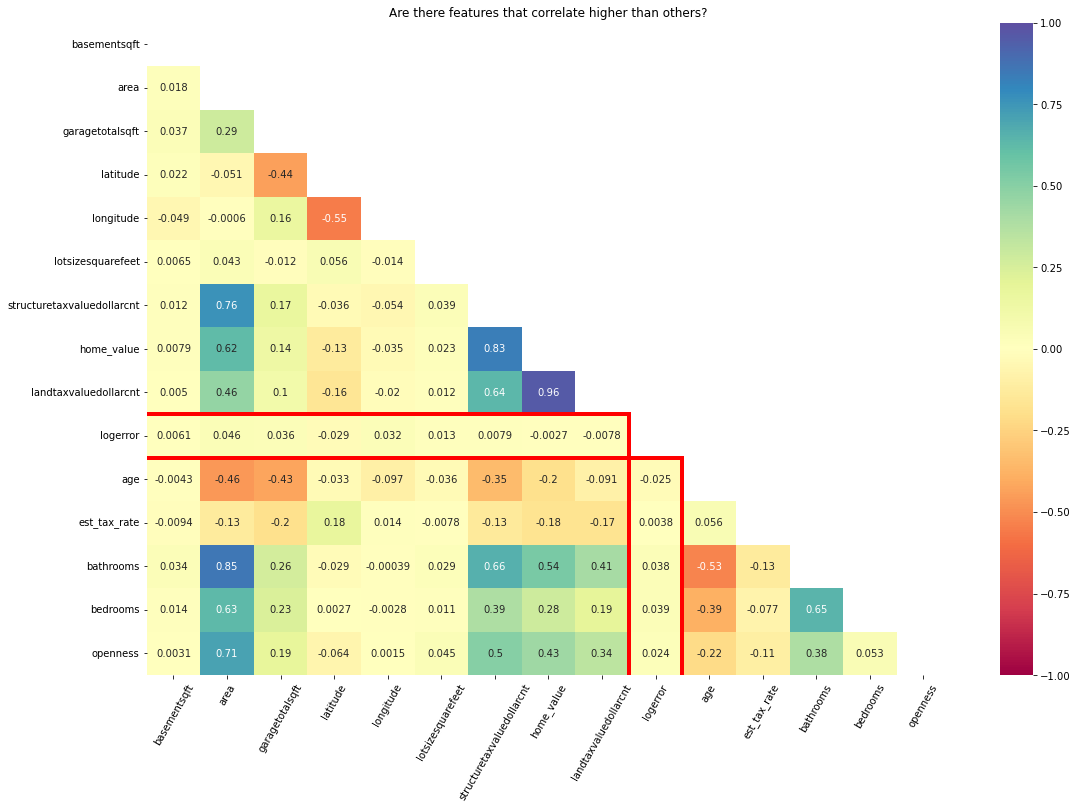

In [3]:
explore_zillow.explore_inital_guidance(train)

No strong relationships are sticking out, Area being the strongest candidate

> ### Question 1 -  Does logerror and Area(sqft) have a signifcant relationship
> ${H_0}$: There is not a significant relationship in LogError and Area   
> ${H_a}$: There is a significant relationship in LogError and Area   
> ${\alpha}$: .05

> Result: There is enough evidence to reject our null hypothesis. **Test code below**

Results of SpearmanR (r = 0.081|p = 0.0


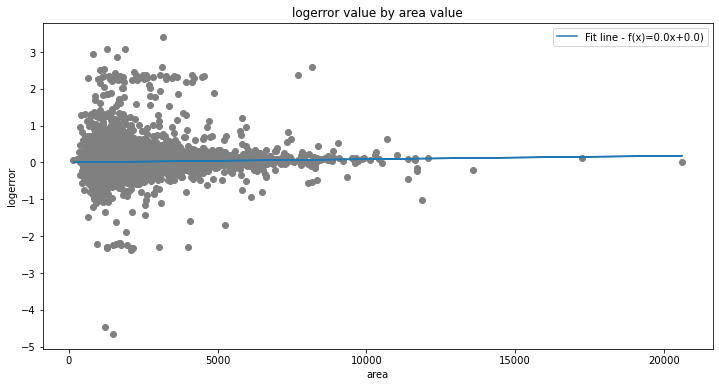

In [4]:
## assigns two variables to be used in the scatterplot, which has a polyline(1) plotted over it,
## Also runs a SpearmanR correlation test and returns the values
col1,target = "area", "logerror"
plt.figure(figsize=(12, 6))
x,y = train[col1], train[target]
r, p = spearmanr(x,y)
plt.plot(x, y, "o",color="grey")
m,b = np.polyfit(x,y,1)
print(f"Results of SpearmanR (r = {round(r,3)}|p = {round(p,3)}")
plt.plot(x,m*x+b,label=f"Fit line - f(x)={round(m,3)}x+{round(b,0)})")
plt.xlabel(col1), plt.ylabel(target)
plt.legend(), plt.title(f"{target} value by {col1} value")
plt.show()

> #### Q1 takeway:
- Due to having a p value less than our alpha we were able to determine that there is a relationshiop that we can utilize in our modeling
- Use results of test fo formulate basis for creating Clusters based on house sizing that included : `area`, `bathrooms`, and `bedrooms`

### Question 2 - Is there a difference in the the sample of no Heating for Log Error?
${H_0}$: There is no significant difference in mean `logerror` between properties with `no_heating` and the wider population
${H_a}$: There is significant difference in mean `logerror` between properties with `no_heating` and the wider population  
${\alpha}$: .05

> Result: There is enough evidence to reject our null hypothesis.   
> **Test code below** :function in module does a 1 sample TTest against the population

In [5]:
df.heating.value_counts()

Central       20407
None          18302
Floor/Wall    12438
Other           589
Name: heating, dtype: int64

In [6]:
train.heating.value_counts()

Central       11444
None          10197
Floor/Wall     7021
Other           309
Name: heating, dtype: int64


 We reject the null Hypothesis ( N̶o̶n̶e̶ ̶a̶s̶ ̶a̶ ̶s̶a̶m̶p̶l̶e̶ ̶h̶a̶s̶ ̶e̶q̶u̶a̶l̶ ̶m̶e̶a̶n̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶h̶e̶a̶t̶i̶n̶g̶ ̶a̶s̶ ̶a̶ ̶p̶o̶p̶u̶l̶a̶t̶i̶o̶n̶ ̶r̶e̶g̶a̶r̶d̶i̶n̶g̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶ ) t=4.02012, p=0.00006


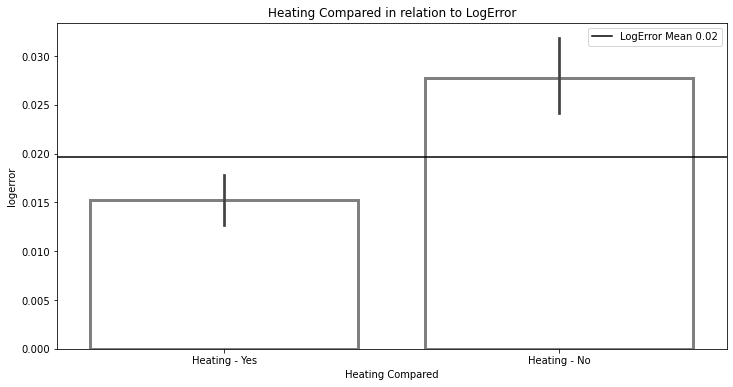

In [7]:
## function in module does a 1 sample TTest against the population and 
## returns the result for Heating(None), plots the feature as sampled
explore_zillow.explore_heating(train)

> #### Q2 takeway:
- Whether you have heating, or not, does significantly affect LogError, and as such should be considered in Modeling for prediction
- Added consideration of heating capability to feature selection phase of Modeling

### Guidance - Clusters
Run statistical tests and viz on the clusters to verify if the results of our clustering are signifcant

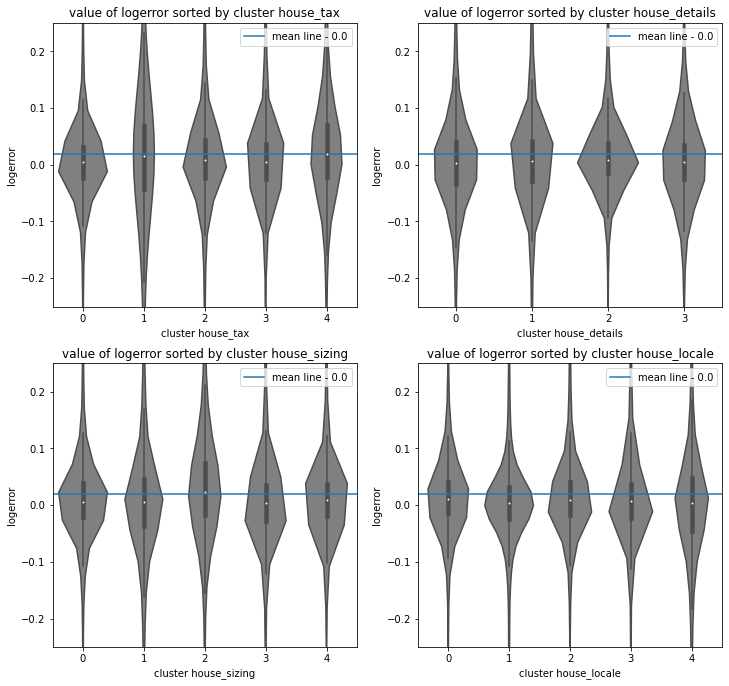

,variable,p_val
13,cluster house_sizing(2),3.999308e-09
14,cluster house_locale(4),5.440983e-07
2,cluster house_tax(0),6.959698e-07
15,cluster house_locale(0),2.725175e-06
8,cluster house_details(2),7.431146e-05


In [8]:
## function in module does a 1 sample TTest against the population for each cluster
## returns the result
explore_zillow.viz_clusters(train,"logerror")
explore_zillow.score_clusters(train,"logerror")[["variable","p_val"]].sort_values(by=["p_val"]).head(5)

We have p values low enough to indicate that there may be relationships to investigate

### Question 3 -  Does the Cluster group of Home Size have any clusters that are significantly different in relation to logerror?
${H_0}$: There is no significant difference in mean LogError of the sample Home Size (Cluster 4) compared to the population  
${H_a}$: There is significant difference in mean LogError of the sample Home Size (Cluster 4) compared to the population  
${\alpha}$: .05

> Result: There is enough evidence to reject our null hypothesis.  
> **Test code below**: function runs a tailored ttest and plots the feature for this question


 We fail to reject the null hypothesis ( 4 as a sample has equal mean values to cluster house_sizing as a population regarding logerror ) t=1.62968, p=0.10321


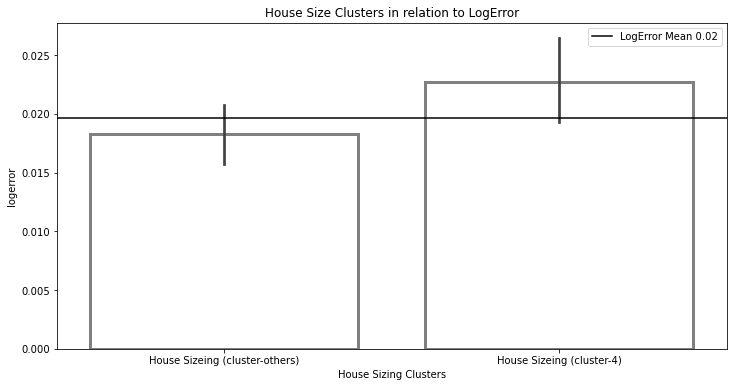

In [9]:
## function tailored for this question. does a sample ttest and returns results with a plot of the feature
explore_zillow.explore_house_size_clusters(train)

> #### Q3 takeway:
- The amount of area(sqft), bedrooms, and bathrooms play a role in the ability to predict logerror, with our Cluster ????? being divergent compared to the population
- Used information to ensure house size clusters were included in feature consideration

### Question 4 -  Does the Cluster group based on Locale have any clusters that are significantly different in relation to logerror?
${H_0}$: There is no significant difference in mean LogError of the sample House Locale (Cluster 1) compared to the population  
${H_a}$: There is significant difference in mean LogError of the sample House Locale (Cluster 1) compared to the population  
${\alpha}$: .05

> Result: There is enough evidence to reject our null hypothesis. 
> **Test code below**: function runs a tailored ttest and plots the feature


 We fail to reject the null hypothesis ( 1 as a sample has equal mean values to cluster house_locale as a population regarding logerror ) t=-1.17917, p=0.23844


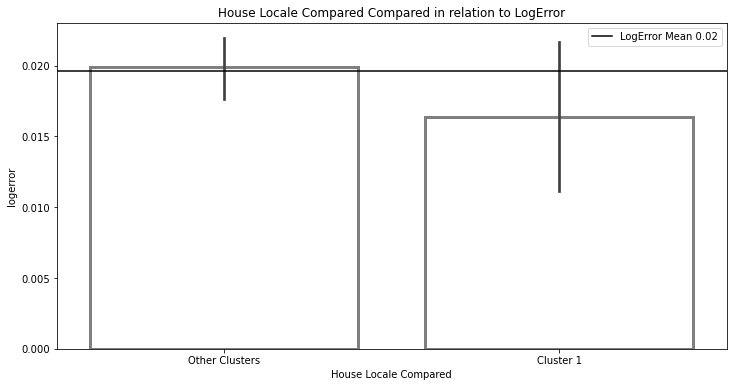

In [10]:
## function tailored for this question. does a sample ttest and returns results with a plot of the feature
explore_zillow.explore_house_locale_cluster(train)

> - #### Q4 takeway:
> - The amount of location (lat and long), and age play a role in the ability to predict logerror, with our Cluster 1 being divergent compared to the population

## Exploration Takeaways
> - A combination of features and clusters will likely give us the best result to predict log error
> - These features may include: Area, Heating, Cluster of Home Size -Area(sqft), Bedroom, Bathroom, Location, and age will all prove to have a level of significance in helping predict our target variable of log error in our modeling

# Modeling

In [11]:
#call modeling preparation function to acquire train/validate/test subsets
X_train, y_train, X_val, y_val, X_test, y_test = model.modeling_prep(train, train_scaled, validate, validate_scaled, test, test_scaled)

In [12]:
#model and score various functions and find list of best four performing
train_scores = model.score_on_train(X_train, y_train)

['area', 'lotsizesquarefeet', 'structuretaxvaluedollarcnt', 'home_value', 'landtaxvaluedollarcnt', 'openness', 'tax_per_sqft', 'poolcnt_1.0', 'cluster house_details_0.3333333333333333', 'cluster house_details_0.6666666666666666']
['bathrooms', 'bedrooms', 'area', 'garagecarcnt', 'garagetotalsqft', 'county_Orange County', 'home_size_large', 'heating_None', 'cluster house_sizing_0.5', 'cluster house_locale_1.0']


In [13]:
#model and score various functions and find list of best three performing
top_four = train_scores.sort_values(by='RMSE').head(4)

In [14]:
top_four

,Name,RMSE,r^2 score,Features,Parameters
1,Polynomial_1,0.185098,0.016041,"[cluster house_tax_0.25, cluster house_tax_0.5...",Degree: 2
2,Polynomial_2,0.185316,0.013723,"[cluster house_details_0.3333333333333333, clu...",Degree: 2
3,Polynomial_3,0.185356,0.013299,"[cluster house_sizing_0.25, cluster house_sizi...",Degree: 2
5,Polynomial_5,0.185782,0.008755,"[bathrooms, bedrooms, area, garagecarcnt, gara...",Degree: 2


## Validation Scoring
* Polynomials 2 
    - Degrees: 3
    - Features: All



In [15]:
validate_scores, y_val = model.score_on_validate(train_scores, X_val, y_val, X_train, y_train)

In [18]:
validate_scores.sort_values(by='RMSE').head(20)

,Name,RMSE,r^2 score,Features,Parameters
16,GLM_1,0.165618,2.134117e-03,-,"Power,Alpha: (0, 0)"
17,GLM_2,0.165653,1.437300e-03,-,"Power,Alpha: (0, 0.25)"
6,OLS_1,0.165656,1.660900e-03,"[cluster house_tax_0.25, cluster house_tax_0.5...",N/A
18,GLM_3,0.165678,1.232875e-03,-,"Power,Alpha: (0, 0.5)"
8,OLS_3,0.165682,1.342349e-03,"[cluster house_sizing_0.25, cluster house_sizi...",N/A
19,GLM_4,0.165694,1.081922e-03,-,"Power,Alpha: (0, 0.75)"
20,GLM_5,0.165706,NaN,-,"Power,Alpha: (0, 1)"
7,OLS_2,0.165711,1.006910e-03,"[cluster house_details_0.3333333333333333, clu...",N/A
9,OLS_4,0.165711,9.907227e-04,"[cluster house_locale_0.25, cluster house_loca...",N/A
10,OLS_5,0.165759,4.579216e-04,"[bathrooms, bedrooms, area, garagecarcnt, gara...",N/A


## Test
* GLM 1
    - Power: 3
    - Alpha: 0
    - Features: All features
    - Cluster labels created using location, size, home details, and tax information 

 ### Model Code       
    def score_on_test(X_test, y_test, X_train, y_train):
        #reset y_test variable to remove scores from previous model
        y_test = y_test[['logerror', 'pred_median']]

        #find rmse of baseline predictions 
        test_pred_rmse = mean_squared_error(y_test.logerror, y_test.pred_median, squared=False)

        #creates dataframe to hold model score on test set
        test_score = pd.DataFrame([['pred_median', test_pred_rmse, 0, 'N/A', 'N/A']], 
                        columns=['Name','RMSE', 'r^2 score','Features', 'Parameters'])

        #select parameters or features for final modeling on test set
        #test_selectors = [(['bedrooms', 'area', 'county_Orange County', 'home_size_large'], 2)]
        test_parameters = [(0,0)]

        #fit and use the model that scored highest on validate set
        #test_score, holder = pf_mod(X_test, y_test, test_selectors, test_score, X_train, y_train)
        test_score, holder = GLM_mod(X_test, y_test, test_parameters, test_score, X_train, y_train)

        #adds correct model name to data frame
        test_score.iat[1, 0] = 'GLM_1'

        #add r^2 score 
        test_score.iat[1,2] = explained_variance_score(y_test['logerror'], y_test.iloc[:,2])
        print(y_test.iloc[:,2])

        return test_score

In [17]:
#calls function from  model module to fit and test the best perfoming model on the test subset 
model.score_on_test(X_test, y_test, X_train, y_train)

id
2181062    0.011196
2709432    0.063418
1440501    0.026875
2035409    0.024962
1561917    0.009231
             ...   
2507645    0.021481
932951     0.012146
943748    -0.004491
1965404    0.026028
2371483    0.009263
Name: GLM_1, Length: 10348, dtype: float64


,Name,RMSE,r^2 score,Features,Parameters
0,pred_median,0.153141,0.000000,N/A,N/A
1,GLM_1,0.152756,0.001438,-,"Power,Alpha: (0, 0)"


# Conclusion

## Summary of Key Findings
* 
* 
* 

## Suggestions and Next Steps
* No suggestions this time as the model does not beat baseline predictions
* Take a look at adding distance relationships
    - Distance from: water, schools, parks, etc. 
* Explore garages and other add-on data such as pools
    - Be willing to impute more data
* Investigate walk/bike/transit scores
* May consider creating county specific models
* Take steps to correct or add null/missing data from properties